# Sarnia Census Tract Analysis

This notebook processes and analyzes census tract data for Sarnia, Ontario, including downloading, filtering, and visualizing the geographical information.


## Plot Style Configuration
The notebook uses the `seaborn-v0_8-white` style for consistent and clean visualizations:


## Key Functions

### 1. `download_census_tracts()`

This function handles the downloading and extraction of census tract boundary data:

- Creates a 'data' directory if it doesn't exist
- Downloads census tract boundaries from Statistics Canada
- Shows a progress bar during download
- Extracts the downloaded zip file
- Returns the path to the extracted shapefile


### 2. `get_sarnia_tracts(shapefile_path)`

This function processes the census tract data specifically for Sarnia:

- Loads the shapefile using GeoPandas
- Projects coordinates to EPSG:3857 (Web Mercator) for processing
- Filters tracts within Sarnia's geographical bounds:
  - Latitude: 42.95° to 43.05°
  - Longitude: -82.45° to -82.30°
- Creates a visualization of the found census tracts
- Returns a filtered GeoDataFrame containing only Sarnia's census tracts



## Visualization Details

The notebook creates a map visualization with the following features:
- Census tract boundaries plotted with 50% transparency
- Black boundary lines for clear tract delineation
- CartoDB Positron basemap for context
- Clean layout with removed axes for better presentation
- Automatically adjusted layout to prevent title cutoff

## Data Sources

- Census tract boundaries are sourced from Statistics Canada's 2021 Census
- URL: `https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/files-fichiers/lct_000b21a_e.zip`

## Output

The script provides:
1. Progress updates during download and processing
2. Confirmation of successful data extraction
3. Count of census tracts found in Sarnia
4. Interactive map visualization of the census tracts

## Notes

- The coordinate system is converted between EPSG:4326 (WGS84) and EPSG:3857 (Web Mercator) as needed for different operations
- The tqdm library is used to show progress during the download process
- The script includes error handling for file operations and data processing

In [8]:
# Part 1: Imports and Basic Setup
import os
import requests
import zipfile
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import osmnx as ox
import pandas as pd
import numpy as np
import folium
from shapely.geometry import box, Point
import networkx as nx
from collections import Counter
from tqdm import tqdm
from IPython.display import display, HTML
# Use a proper style name
plt.style.use('seaborn-v0_8-white')  # or just remove the style setting


def download_census_tracts():
    """
    Downloads and extracts Sarnia census tract boundaries.
    Returns the path to the extracted shapefile.
    """
    if not os.path.exists('data'):
        os.makedirs('data')
    print("\n1. DOWNLOADING CENSUS DATA")
    print("==========================")
    url = "https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/files-fichiers/lct_000b21a_e.zip"
    zip_path = "data/census_tracts.zip"
    
    if not os.path.exists(zip_path):
        print("Downloading census tract boundaries...")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024
        
        with open(zip_path, 'wb') as f:
            for data in tqdm(response.iter_content(block_size), 
                           total=total_size//block_size, 
                           unit='KB', 
                           desc="Download Progress"):
                f.write(data)
    
    print("Extracting files...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')
    print("✓ Census data downloaded and extracted\n")
    return 'data/lct_000b21a_e.shp'

def get_sarnia_tracts(shapefile_path):
    """Load and filter Sarnia census tracts"""
    print("\n2. PROCESSING CENSUS TRACTS")
    print("===========================")
    print("Loading shapefile...")
    gdf = gpd.read_file(shapefile_path)
    
    print("Converting coordinate systems...")
    gdf_projected = gdf.to_crs('EPSG:3857')
    
    sarnia_bounds = {
        'min_lat': 42.95,
        'max_lat': 43.05,
        'min_lon': -82.45,
        'max_lon': -82.30
    }
    
    print("Filtering for Sarnia area...")
    bounds_gdf = gpd.GeoDataFrame(
        geometry=[Point(sarnia_bounds['min_lon'], sarnia_bounds['min_lat'])],
        crs='EPSG:4326'
    ).to_crs('EPSG:3857')
    
    min_x, min_y = bounds_gdf.geometry.iloc[0].x, bounds_gdf.geometry.iloc[0].y
    
    bounds_gdf = gpd.GeoDataFrame(
        geometry=[Point(sarnia_bounds['max_lon'], sarnia_bounds['max_lat'])],
        crs='EPSG:4326'
    ).to_crs('EPSG:3857')
    
    max_x, max_y = bounds_gdf.geometry.iloc[0].x, bounds_gdf.geometry.iloc[0].y
    
    sarnia_mask = (
        gdf_projected.geometry.centroid.y.between(min_y, max_y) &
        gdf_projected.geometry.centroid.x.between(min_x, max_x)
    )
    
    filtered_gdf = gdf_projected[sarnia_mask].to_crs('EPSG:4326').copy()
    print(f"✓ Found {len(filtered_gdf)} census tracts in Sarnia\n")
    
    # Quick visualization of found tracts with clean map display
    fig, ax = plt.subplots(figsize=(10, 10))
    filtered_gdf.to_crs('EPSG:3857').plot(
        ax=ax, 
        alpha=0.5, 
        edgecolor='black',
        linewidth=1
    )
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_title('Found Census Tracts in Sarnia', pad=20)
    
    # Remove axes and numbers
    ax.set_axis_off()
    
    # Adjust layout to prevent title cutoff
    plt.tight_layout()
    plt.show()
    
    return filtered_gdf

# Part 2: Feature Analysis Functions

This section contains functions for analyzing amenities, points of interest (POIs), and street network characteristics within Sarnia's census tracts.

## Function Details

### 1. `get_amenities_and_pois(polygon, tags, category_name, tract_id)`

Retrieves and processes amenities and points of interest within a specified polygon.

**Parameters:**
- `polygon`: Geographic polygon defining the area of interest
- `tags`: OSM tags to filter specific amenities
- `category_name`: Name of the amenity category
- `tract_id`: Census tract identifier

**Key Features:**
- Error handling for geometry processing
- Automatic name generation for unnamed features
- Coordinate extraction from various geometry types
- Comprehensive feature attribute collection

**Output DataFrame Columns:**
```python
[
    'name',            # Feature name or auto-generated identifier
    'category',        # Category of the amenity
    'tract_id',        # Census tract identifier
    'latitude',        # Feature latitude
    'longitude',       # Feature longitude
    'amenity_type',    # OSM amenity classification
    'leisure_type',    # OSM leisure classification
    'shop_type',       # OSM shop classification
    'type_description' # Consolidated type information
]
```

### 2. `analyze_tract_features(polygon, tract_id)`

Performs comprehensive analysis of a single census tract's features.

**Analysis Components:**
1. Street Network Analysis:
   - Node count and edge count
   - Total edge length (km)
   - Average node degree
   - Edge density calculation

2. Amenity Categories Analyzed:
```python
{
    'restaurants': ['restaurant', 'fast_food', 'cafe', 'bar', 'pub'],
    'shops': ['supermarket', 'convenience', 'clothes', 'hardware', 'department_store'],
    'education': ['school', 'university', 'college', 'library', 'kindergarten'],
    'healthcare': ['hospital', 'clinic', 'pharmacy', 'doctors', 'dentist'],
    'recreation': ['sports_centre', 'pitch', 'swimming_pool', 'park', 'playground'],
    'parks': ['park'],
    'public_transport': ['station', 'stop_position', 'platform'],
    'community': ['community_centre', 'place_of_worship', 'police', 'fire_station', 'post_office']
}
```

**Returns:**
- Tract analysis results dictionary
- List of amenity DataFrames

### 3. `analyze_all_tracts(sarnia_tracts)`

Processes all census tracts and consolidates results.

**Key Operations:**
- Iterates through all census tracts
- Consolidates individual tract analyses
- Generates comprehensive amenities dataset
- Creates merged dataset with tract geometries and metrics

**Output:**
1. Saves complete amenities dataset to 'sarnia_locations.csv'
2. Returns GeoDataFrame with tract geometries and calculated metrics

## Data Processing Notes

1. **OSMnx Settings:**
```python
ox.settings.log_console = True
ox.settings.use_cache = True
```

2. **Area Calculations:**
- Converts geometries to EPSG:3857 for accurate area calculations
- Areas calculated in square kilometers

3. **Density Metrics:**
- Edge density = total edge length / tract area
- Amenity density = amenity count / tract area

## Error Handling

- Comprehensive error handling at each processing step
- Graceful failure for individual tracts without affecting overall analysis
- Detailed progress reporting and error messages

## Output Data Structure

The final GeoDataFrame includes:
- Original census tract geometries and attributes
- Network metrics (node count, edge count, densities)
- Amenity counts and densities by category
- Area calculations and derived metrics


In [9]:
def get_amenities_and_pois(polygon, tags, category_name, tract_id):
    """
    Get amenities and POIs within a polygon with error handling
    """
    try:
        print(f"  - Fetching {category_name}...", end='', flush=True)
        
        # Convert polygon to GeoDataFrame if it's not already
        if not isinstance(polygon, gpd.GeoDataFrame):
            polygon_gdf = gpd.GeoDataFrame(geometry=[polygon], crs='EPSG:4326')
        else:
            polygon_gdf = polygon
            
        amenities = ox.features_from_polygon(polygon, tags)
        
        if len(amenities) == 0:
            print(" None found")
            return pd.DataFrame()
        
        print(f" Found {len(amenities)} features")
        if not isinstance(amenities, gpd.GeoDataFrame):
            amenities = gpd.GeoDataFrame(amenities)

        # Create list to store amenity data
        amenity_data = []
        
        # Process each amenity
        for idx, amenity in amenities.iterrows():
            try:
                # Get coordinates from geometry
                if hasattr(amenity.geometry, 'geom_type'):
                    if amenity.geometry.geom_type == 'Point':
                        lat, lon = amenity.geometry.y, amenity.geometry.x
                    else:
                        centroid = amenity.geometry.centroid
                        lat, lon = centroid.y, centroid.x
                else:
                    continue
                
                # Determine amenity type for naming
                amenity_type = amenity.get('amenity', '')
                leisure_type = amenity.get('leisure', '')
                shop_type = amenity.get('shop', '')
                
                # Get or generate name with proper type handling
                name = str(amenity.get('name', '')).strip()
                
                if not name or name.lower() == 'nan':
                    # Determine primary type
                    if amenity_type:
                        type_for_name = amenity_type
                    elif leisure_type:
                        type_for_name = leisure_type
                    elif shop_type:
                        type_for_name = shop_type
                    else:
                        type_for_name = category_name
                    
                    # Format type name
                    type_name = type_for_name.replace('_', ' ').title()
                    name = f"{type_name} at Tract {tract_id}"
                
                # Create amenity record
                record = {
                    'name': name,  # This will now always have a value
                    'category': category_name,
                    'tract_id': tract_id,
                    'latitude': lat,
                    'longitude': lon,
                    'amenity_type': amenity_type,
                    'leisure_type': leisure_type,
                    'shop_type': shop_type
                }
                
                # Set type description based on the actual type
                if amenity_type:
                    record['type_description'] = amenity_type
                elif leisure_type:
                    record['type_description'] = leisure_type
                elif shop_type:
                    record['type_description'] = shop_type
                else:
                    record['type_description'] = 'unknown'
                
                amenity_data.append(record)
                
            except Exception as e:
                print(f"\nWarning: Error processing amenity: {str(e)}")
                continue
        
        # Create DataFrame from processed data
        if amenity_data:
            clean_data = pd.DataFrame(amenity_data)
            
            # Final check to ensure no NaN values in name column
            clean_data['name'] = clean_data.apply(
                lambda x: f"{x['type_description'].replace('_', ' ').title()} at Tract {tract_id}" 
                if pd.isna(x['name']) or str(x['name']).strip() == '' 
                else x['name'], 
                axis=1
            )
            
            print(f" Successfully processed {len(clean_data)} features")
            return clean_data
        else:
            print(" No valid features found")
            return pd.DataFrame()
        
    except Exception as e:
        print(f" Error: {str(e)}")
        return pd.DataFrame()
    
def analyze_tract_features(polygon, tract_id):
    """
    Analyze street network, amenities, and POIs for a given census tract
    """
    print(f"\nAnalyzing tract {tract_id}")
    print("-" * (len(str(tract_id)) + 15))
    
    try:
        # Configure OSMnx settings
        ox.settings.log_console = True
        ox.settings.use_cache = True
        
        print("1. Downloading street network...")
        graph = ox.graph_from_polygon(polygon, network_type='drive', simplify=True)
        
        # Calculate basic stats manually
        node_count = len(graph.nodes)
        edge_count = len(graph.edges)
        
        # Calculate total edge length
        edge_lengths = []
        for u, v, data in graph.edges(data=True):
            if 'length' in data:
                edge_lengths.append(data['length'])
        total_edge_length_km = sum(edge_lengths) / 1000  # Convert from meters to kilometers
        
        # Calculate average node degree
        degrees = [d for n, d in graph.degree()]
        avg_node_degree = sum(degrees) / len(degrees) if degrees else 0
        
        print(f"   ✓ Found {node_count} nodes and {edge_count} edges")
        
        # Convert polygon to GeoDataFrame for proper CRS conversion
        if not isinstance(polygon, gpd.GeoDataFrame):
            polygon_gdf = gpd.GeoDataFrame(geometry=[polygon], crs='EPSG:4326')
        else:
            polygon_gdf = polygon
            
        # Calculate area in km2
        area_km2 = polygon_gdf.to_crs('EPSG:3857').geometry.area.iloc[0] / 1e6
        
        # Calculate edge density
        edge_density_km = total_edge_length_km / area_km2 if area_km2 > 0 else 0
        
        # Define tags for different categories
        tags_dict = {
            'restaurants': {'amenity': ['restaurant', 'fast_food', 'cafe', 'bar', 'pub']},
            'shops': {'shop': ['supermarket', 'convenience', 'clothes', 'hardware', 'department_store']},
            'education': {'amenity': ['school', 'university', 'college', 'library', 'kindergarten']},
            'healthcare': {'amenity': ['hospital', 'clinic', 'pharmacy', 'doctors', 'dentist']},
            'recreation': {'leisure': ['sports_centre', 'pitch', 'swimming_pool', 'park', 'playground']},
            'parks': {'leisure': 'park'},
            'public_transport': {'public_transport': ['station', 'stop_position', 'platform']},
            'community': {'amenity': ['community_centre', 'place_of_worship', 'police', 'fire_station', 'post_office']}
        }
        
        print("\n2. Fetching amenities and POIs...")
        features = {}
        all_amenities = []
        
        for category, tags in tags_dict.items():
            df = get_amenities_and_pois(polygon, tags, category, tract_id)
            features[f'{category}_count'] = len(df) if not df.empty else 0
            features[f'{category}_density'] = features[f'{category}_count'] / area_km2 if area_km2 > 0 else 0
            
            if not df.empty:
                all_amenities.append(df)
        
        result = {
            'tract_id': tract_id,
            'node_count': node_count,
            'edge_count': edge_count,
            'total_edge_length_km': total_edge_length_km,
            'edge_density_km': edge_density_km,
            'average_node_degree': avg_node_degree,
            'area_km2': area_km2,
            **features
        }
        
        print("\n✓ Analysis complete for tract", tract_id)
        return result, all_amenities
        
    except Exception as e:
        print(f"\n✗ Error analyzing tract {tract_id}: {str(e)}")
        return None, None

def analyze_all_tracts(sarnia_tracts):
    """
    Analyze features for all census tracts
    """
    print("\n3. ANALYZING ALL CENSUS TRACTS")
    print("==============================")
    
    ox.settings.log_console = True
    ox.settings.use_cache = True
    
    results = []
    all_amenities = []
    total_tracts = len(sarnia_tracts)
    
    for idx, tract in sarnia_tracts.iterrows():
        print(f"\nProcessing tract {idx + 1} of {total_tracts}")
        result, tract_amenities = analyze_tract_features(tract.geometry, tract['CTUID'])
        if result:
            results.append(result)
            if tract_amenities:
                all_amenities.extend(tract_amenities)
    
    if not results:
        print("\n✗ No successful tract analyses. Cannot continue.")
        return None
        
    results_df = pd.DataFrame(results)
    print("\n✓ Analysis complete for all tracts")
    
    # Save complete amenities dataset
    if all_amenities:
        complete_amenities = pd.concat(all_amenities)
        
        # Ensure columns are in the correct order
        columns = [
            'name', 'category', 'tract_id', 'latitude', 'longitude',
            'amenity_type', 'leisure_type', 'shop_type', 'type_description'
        ]
        
        # Save the complete dataset
        complete_amenities[columns].to_csv('sarnia_locations.csv', index=False)
        print(f"\n✓ Saved complete dataset with {len(complete_amenities)} locations to 'sarnia_locations.csv'")
        
        # Display sample of the data
        print("\nSample of location data:")
        print(complete_amenities[columns].head())
    
    # Ensure CTUID is string type in both DataFrames
    sarnia_tracts['CTUID'] = sarnia_tracts['CTUID'].astype(str)
    results_df['tract_id'] = results_df['tract_id'].astype(str)
    
    sarnia_tracts_with_metrics = sarnia_tracts.merge(
        results_df, 
        left_on='CTUID', 
        right_on='tract_id',
        how='left'
    )
    
    return sarnia_tracts_with_metrics

# Part 3: Visualization, Reporting, and Main Analysis

This section covers the functions for creating summary reports, visualizing amenities, and running the complete analysis pipeline.

## Summary Report Generation

### `create_summary_report(sarnia_tracts_with_metrics, locations_df)`

Creates a comprehensive statistical summary of the analyzed data.

**Calculated Metrics:**
```python
summary_metrics = {
    'Total Amenities',
    'Total Restaurants',
    'Total Shops',
    'Total Educational Facilities',
    'Total Healthcare Facilities',
    'Total Parks',
    'Total Community Centers',
    'Total Road Length (km)',
    'Average Edge Density',
    'Total Area (km²)',
    'Overall Amenity Density (per km²)'
}
```

**Usage:**
```python
summary = create_summary_report(sarnia_tracts_with_metrics, locations_df)
print(summary)
```

## Interactive Visualization

### `visualize_amenities(sarnia_tracts_with_metrics, locations_df)`

Creates an interactive web map using Folium to visualize all amenities and features.

**Map Features:**
- Base map: CartoDB Positron for clean street display
- Census tract boundaries
- Color-coded amenity points
- Interactive layer control

**Color Scheme:**
```python
category_colors = {
    'shops': '#4285F4',          # Blue
    'recreation': '#34A853',     # Green
    'community': '#9334E6',      # Purple
    'restaurants': '#EA4335',    # Red
    'education': '#FBBC05',      # Yellow/Gold
    'healthcare': '#8B0000',     # Dark Red
    'parks': '#90EE90',          # Light Green
    'public_transport': '#48D1CC' # Turquoise
}
```

**Output:**
- Saves interactive map as 'sarnia_amenities.html'
- Returns Folium map object for in-notebook display

## Main Analysis Pipeline

### `run_analysis()`

Orchestrates the complete analysis workflow from data download to visualization.

**Pipeline Steps:**
1. Downloads census tract data
2. Prepares Sarnia tract boundaries
3. Analyzes features for each tract
4. Loads and processes location data
5. Creates visualizations
6. Generates summary report

**Usage:**
```python
# Run complete analysis
sarnia_tracts_with_metrics, locations_df = run_analysis()
```

**Return Values:**
- `sarnia_tracts_with_metrics`: GeoDataFrame with tract geometries and metrics
- `locations_df`: DataFrame containing all amenity locations

## Running the Script

When run as a main program, the script executes the complete analysis pipeline:

```python
if __name__ == "__main__":
    sarnia_tracts_with_metrics, locations_df = run_analysis()
```

## Output Files

The analysis generates several output files:
1. `sarnia_locations.csv`: Complete dataset of all amenities and POIs
2. `sarnia_amenities.html`: Interactive web map visualization

## Error Handling

- Comprehensive error handling at each stage
- Detailed error messages and progress reporting
- Graceful failure handling with appropriate user feedback



SARNIA CENSUS TRACT ANALYSIS

1. DOWNLOADING CENSUS DATA
Extracting files...
✓ Census data downloaded and extracted


2. PROCESSING CENSUS TRACTS
Loading shapefile...
Converting coordinate systems...
Filtering for Sarnia area...
✓ Found 18 census tracts in Sarnia



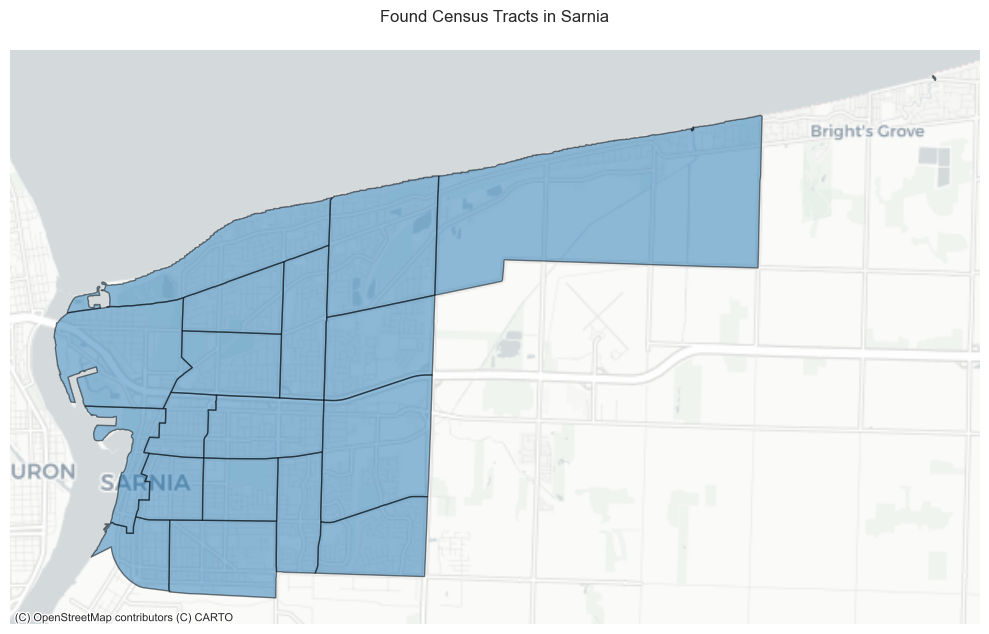


3. ANALYZING ALL CENSUS TRACTS

Processing tract 1600 of 18

Analyzing tract 5620002.00
-------------------------
1. Downloading street network...
   ✓ Found 58 nodes and 150 edges

2. Fetching amenities and POIs...
  - Fetching restaurants... Error: No data elements in server response. Check log and query location/tags.
  - Fetching shops... Found 1 features
 Successfully processed 1 features
  - Fetching education... Error: No data elements in server response. Check log and query location/tags.
  - Fetching healthcare... Error: No data elements in server response. Check log and query location/tags.
  - Fetching recreation... Found 9 features
 Successfully processed 9 features
  - Fetching parks... Found 1 features
 Successfully processed 1 features
  - Fetching public_transport... Error: No data elements in server response. Check log and query location/tags.
  - Fetching community... Found 4 features
 Successfully processed 4 features

✓ Analysis complete for tract 5620002.00

Proce

   ✓ Found 75 nodes and 196 edges

2. Fetching amenities and POIs...
  - Fetching restaurants... Error: No data elements in server response. Check log and query location/tags.
  - Fetching shops... Error: No data elements in server response. Check log and query location/tags.
  - Fetching education... Found 1 features
 Successfully processed 1 features
  - Fetching healthcare... Error: No data elements in server response. Check log and query location/tags.
  - Fetching recreation... Found 9 features
 Successfully processed 9 features
  - Fetching parks... Found 4 features
 Successfully processed 4 features
  - Fetching public_transport... Error: No data elements in server response. Check log and query location/tags.
  - Fetching community... Found 4 features
 Successfully processed 4 features

✓ Analysis complete for tract 5620011.00

Processing tract 1610 of 18

Analyzing tract 5620012.00
-------------------------
1. Downloading street network...
   ✓ Found 67 nodes and 166 edges

2. 

C:\Users\user\anaconda3\Lib\site-packages\osmnx\features.py:1053: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  gdf = gdf.dropna(axis="columns", how="all")


 Found 2 features
 Successfully processed 2 features
  - Fetching healthcare... Found 2 features
 Successfully processed 2 features
  - Fetching recreation... Found 8 features
 Successfully processed 8 features
  - Fetching parks... Found 5 features
 Successfully processed 5 features
  - Fetching public_transport... Error: No data elements in server response. Check log and query location/tags.
  - Fetching community... Found 1 features
 Successfully processed 1 features

✓ Analysis complete for tract 5620101.01

Processing tract 3901 of 18

Analyzing tract 5620101.02
-------------------------
1. Downloading street network...
   ✓ Found 92 nodes and 212 edges

2. Fetching amenities and POIs...
  - Fetching restaurants... Error: No data elements in server response. Check log and query location/tags.
  - Fetching shops... Error: No data elements in server response. Check log and query location/tags.
  - Fetching education... Error: No data elements in server response. Check log and query 

In [3]:
def create_summary_report(sarnia_tracts_with_metrics, locations_df):
    """
    Create a summary report of the analysis using both tract metrics and location data
    """
    print("\n5. GENERATING SUMMARY REPORT")
    print("============================")
    
    try:
        # Calculate counts by category
        category_counts = locations_df['category'].value_counts()
        
        # Calculate densities
        total_area = sarnia_tracts_with_metrics['area_km2'].sum()
        
        summary = {
            'Total Amenities': len(locations_df),
            'Total Restaurants': category_counts.get('restaurants', 0),
            'Total Shops': category_counts.get('shops', 0),
            'Total Educational Facilities': category_counts.get('education', 0),
            'Total Healthcare Facilities': category_counts.get('healthcare', 0),
            'Total Parks': category_counts.get('parks', 0),
            'Total Community Centers': category_counts.get('community', 0),
            'Total Road Length (km)': sarnia_tracts_with_metrics['total_edge_length_km'].sum(),
            'Average Edge Density': sarnia_tracts_with_metrics['edge_density_km'].mean(),
            'Total Area (km²)': total_area,
            'Overall Amenity Density (per km²)': len(locations_df) / total_area if total_area > 0 else 0
        }
        
        print("\nSummary Statistics:")
        print("-" * 50)
        for key, value in summary.items():
            print(f"{key}: {value:.2f}")
            
        return pd.Series(summary)
        
    except Exception as e:
        print(f"\n✗ Error generating summary report: {str(e)}")
        return None
    
def visualize_amenities(sarnia_tracts_with_metrics, locations_df):
    """
    Create a single visualization of all amenities in Sarnia with colored dots
    and clearly visible street layout using folium
    """
    print("\nCREATING VISUALIZATION")
    print("=====================")
    
    try:
        # Calculate center of Sarnia
        center_lat = locations_df['latitude'].mean()
        center_lon = locations_df['longitude'].mean()
        
        # Create a folium map centered on Sarnia
        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=13,
            tiles='cartodbpositron'  # Use CartoDB Positron tiles for clean street display
        )
        
        # Define colors for each category
        category_colors = {
            'shops': '#4285F4',      # Blue
            'recreation': '#34A853',  # Green
            'community': '#9334E6',   # Purple
            'restaurants': '#EA4335', # Red
            'education': '#FBBC05',   # Yellow/Gold
            'healthcare': '#8B0000',  # Dark Red
            'parks': '#90EE90',       # Light Green
            'public_transport': '#48D1CC'  # Turquoise
        }
        
        # Add census tracts to the map
        folium.GeoJson(
            sarnia_tracts_with_metrics,
            style_function=lambda x: {
                'fillColor': 'white',
                'fillOpacity': 0.1,
                'color': 'gray',
                'weight': 0.5
            }
        ).add_to(m)
        
        # Create feature groups for each category
        feature_groups = {category: folium.FeatureGroup(name=f"{category.title()} ({len(locations_df[locations_df['category'] == category])})") 
                        for category in category_colors.keys()}
        
        # Add points to respective feature groups
        for idx, row in locations_df.iterrows():
            color = category_colors[row['category']]
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=6,
                color=color,
                fill=True,
                fillColor=color,
                fillOpacity=0.8,
                weight=1,
                popup=row.get('name', '')  # Add popup with name if available
            ).add_to(feature_groups[row['category']])
        
        # Add all feature groups to map
        for group in feature_groups.values():
            group.add_to(m)
        
        # Add layer control
        folium.LayerControl().add_to(m)
        
        # Save the map
        m.save('sarnia_amenities.html')
        print("Map saved as 'sarnia_amenities.html'")
        
        return m
        
    except Exception as e:
        print(f"Error creating visualization: {str(e)}")
        raise


def run_analysis():
    """
    Main function to run the complete analysis
    """
    print("\nSARNIA CENSUS TRACT ANALYSIS")
    print("============================")
    
    try:
        # Download and prepare data
        shapefile_path = download_census_tracts()
        sarnia_tracts = get_sarnia_tracts(shapefile_path)
        
        # Analyze features
        sarnia_tracts_with_metrics = analyze_all_tracts(sarnia_tracts)
        
        if sarnia_tracts_with_metrics is None:
            print("\n✗ Analysis failed - no metrics to visualize")
            return None, None
            
        # Load the locations data
        try:
            locations_df = pd.read_csv('sarnia_locations.csv')
            print(f"\nLoaded {len(locations_df)} locations from data file")
            
            # Create visualizations
            visualize_amenities(sarnia_tracts_with_metrics, locations_df)
            
            # Generate summary
            create_summary_report(sarnia_tracts_with_metrics, locations_df)
            
        except Exception as e:
            print(f"\n✗ Error loading locations data: {str(e)}")
        
        return sarnia_tracts_with_metrics, locations_df
        
    except Exception as e:
        print(f"\n✗ Error in main execution: {str(e)}")
        return None, None

if __name__ == "__main__":
    sarnia_tracts_with_metrics, locations_df = run_analysis()
    

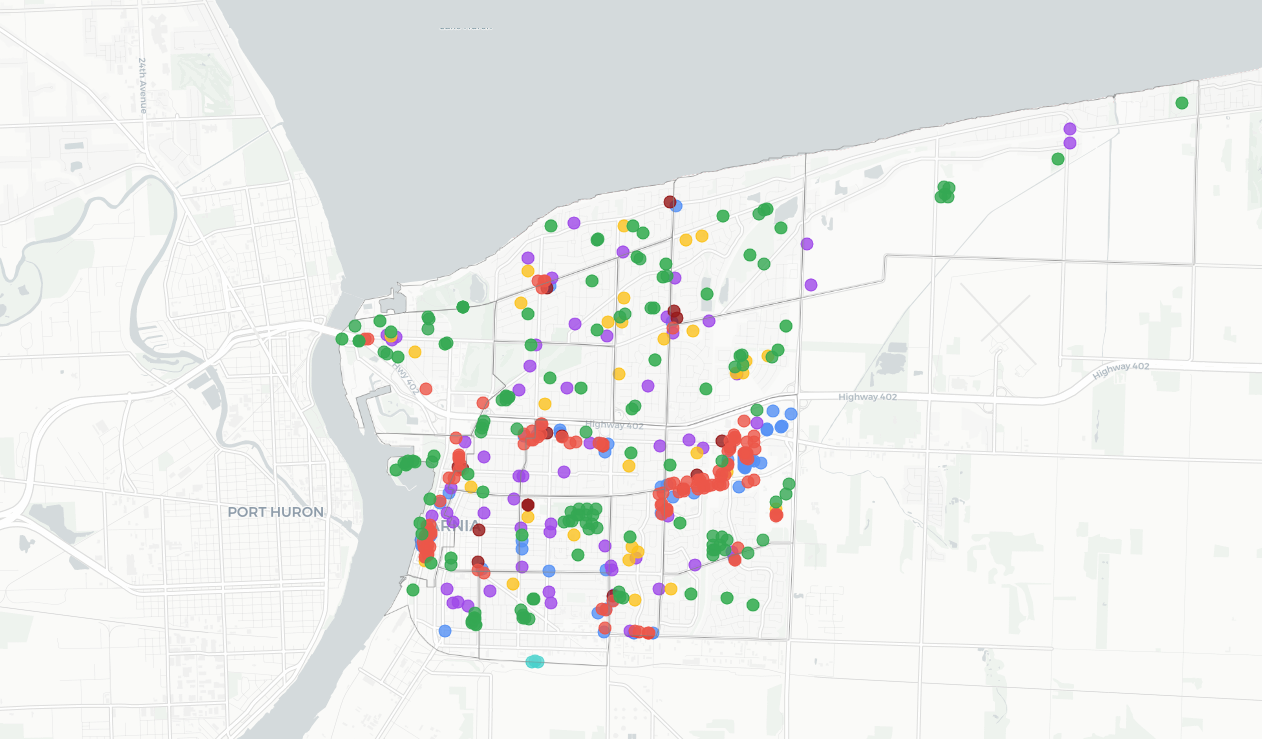